In [3]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RepeatedKFold,StratifiedKFold,GridSearchCV,cross_val_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


# definzioni funzioni varie
def timeserieFeatureExtractor(timeseries):
    timeseries['dayofweek'] = timeseries.index.dayofweek
    timeseries['quarter'] = timeseries.index.quarter
    timeseries['dayofyear'] = timeseries.index.dayofyear
    timeseries['dayofmonth'] = timeseries.index.day
    timeseries['weekofyear'] = timeseries.index.weekofyear
    timeseries['daysinmonth'] = timeseries.index.daysinmonth
    timeseries['month'] = timeseries.index.month
    timeseries['year'] = timeseries.index.year
    timeseries['weekend'] = np.where(timeseries.index.dayofweek > 4, 1, 0)
    timeseries.fillna(0,inplace=True)
    return 

def calcError(y_test, y_pred):
#     R2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = sqrt(MSE)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
#     print(f'R2: {round(R2,4)}')
    print(f'Mean Squared Error: {round(MSE,4)}')
    print(f'Root Mean Sqarred Error: {round(RMSE,4)}')
    print(f'Mean Absolute Error: {round(MAE,4)}')
    print(f'Mean Absolute Percentage Error: {round(MAPE*100,4)}')
    return

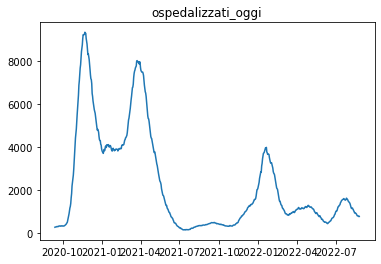

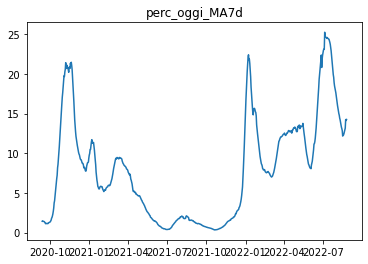

,perc_oggi,ospedalizzati_oggi,ospedalizzati_past1,ospedalizzati_past2,ospedalizzati_past3,ospedalizzati_past4,ospedalizzati_past5,ospedalizzati_past6,perc_past1,perc_past2,...,ospedalizzati_target,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,daysinmonth,month,year,weekend
date,,,,,,,,,,,,,,,,,,,,,
2022-08-16,12.175714,947.0,936.0,946.0,1010.0,1038.0,1096.0,1123.0,12.860000,13.114286,...,800.0,1,3,228,16,33,31,8,2022,0
2022-08-17,12.240000,918.0,947.0,936.0,946.0,1010.0,1038.0,1096.0,12.175714,12.860000,...,775.0,2,3,229,17,33,31,8,2022,0
2022-08-18,12.318571,904.0,918.0,947.0,936.0,946.0,1010.0,1038.0,12.240000,12.175714,...,780.0,3,3,230,18,33,31,8,2022,0
2022-08-19,12.482857,866.0,904.0,918.0,947.0,936.0,946.0,1010.0,12.318571,12.240000,...,780.0,4,3,231,19,33,31,8,2022,0
2022-08-20,12.718571,820.0,866.0,904.0,918.0,947.0,936.0,946.0,12.482857,12.318571,...,780.0,5,3,232,20,33,31,8,2022,1
2022-08-21,12.930000,803.0,820.0,866.0,904.0,918.0,947.0,936.0,12.718571,12.482857,...,694.0,6,3,233,21,33,31,8,2022,1
2022-08-22,13.172857,810.0,803.0,820.0,866.0,904.0,918.0,947.0,12.930000,12.718571,...,688.0,0,3,234,22,34,31,8,2022,0
2022-08-23,14.254286,800.0,810.0,803.0,820.0,866.0,904.0,918.0,13.172857,12.930000,...,680.0,1,3,235,23,34,31,8,2022,0
2022-08-24,14.137143,775.0,800.0,810.0,803.0,820.0,866.0,904.0,14.254286,13.172857,...,655.0,2,3,236,24,34,31,8,2022,0


In [4]:
# creazione dataframe
data = pd.read_csv('https://www.lombacovid.it/story.csv',usecols = ['data','perc_story','ospedalizzati_story'])
data['data'] = pd.to_datetime(data['data'], dayfirst=True)
data.rename(columns = {'ospedalizzati_story':'ospedalizzati_oggi',
                       'perc_story':'perc_oggi',
                       'data':'date'},
                            inplace = True)
data.set_index('date',inplace=True)

  
# 1) feature engineering 
# on perc_oggi smoothed by running average of 7 days
running_average = 7     
data['perc_oggi'] = data['perc_oggi'].rolling(window=running_average).mean()
data = data.dropna()

# creation of ospedalizzati and perc_oggi lag features shifted by 10 days: t, t+1, ... t+n
past_days = 7           # <---
for i in range(1, past_days):
    data[f'ospedalizzati_past{i}'] = data['ospedalizzati_oggi'].shift(i).dropna()
for i in range(1, past_days):
    data[f'perc_past{i}'] = data['perc_oggi'].shift(i).dropna()

# creation of the target: ospedalizzati_oggi lagged by 7 days in the future: t-7
future_target = 7       # <---
data['ospedalizzati_target'] = data['ospedalizzati_oggi'].shift(-future_target).dropna()
data = data.dropna()

# 2) feature extraction
timeserieFeatureExtractor(data)

plt.plot(data.ospedalizzati_oggi)
plt.title('ospedalizzati_oggi')
plt.show()

plt.plot(data.perc_oggi)
plt.title('perc_oggi_MA7d')
plt.show()

data.tail(10)

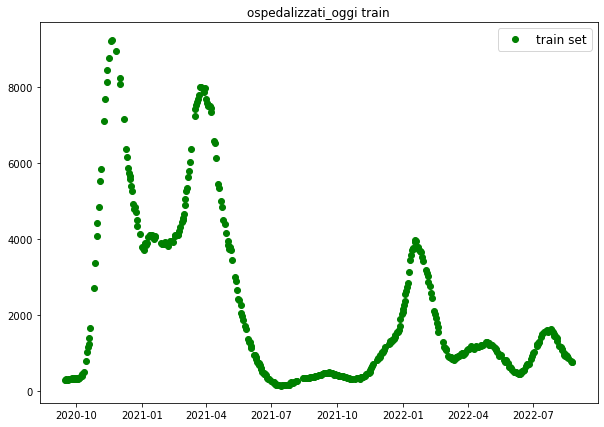

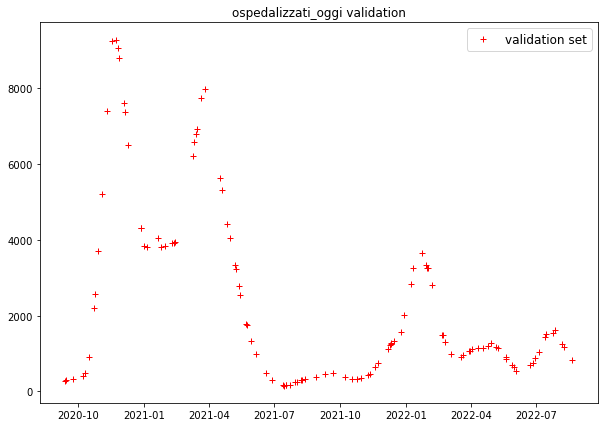

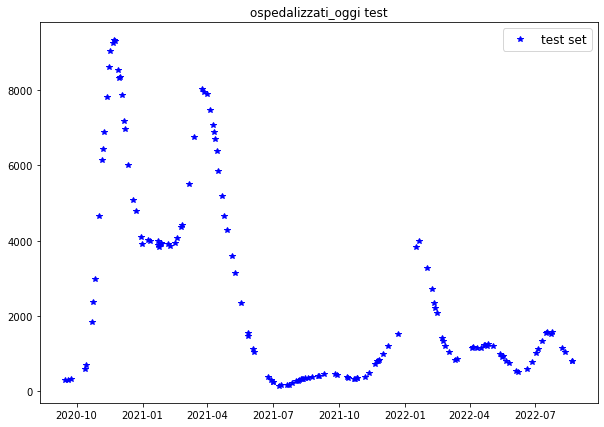

In [5]:
# calculate train, test and validation length using train_test_split
X = data.drop(columns='ospedalizzati_target')
y = data['ospedalizzati_target']

X_train_total, X_test, y_train_total, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_total, y_train_total, test_size=0.20, random_state=42)


plt.figure(figsize=(10,7))
plt.plot(X_train['ospedalizzati_oggi'],'go',label='train set')
plt.title('ospedalizzati_oggi train')
plt.legend(prop={'size': 12})
plt.show()

plt.figure(figsize=(10,7))
plt.plot(X_val['ospedalizzati_oggi'],'r+',label='validation set')
plt.title('ospedalizzati_oggi validation')
plt.legend(prop={'size': 12})
plt.show()

plt.figure(figsize=(10,7))
plt.plot(X_test['ospedalizzati_oggi'],'b*',label='test set')
plt.title('ospedalizzati_oggi test')
plt.legend(prop={'size': 12})
plt.show()

[0]	validation_0-rmse:2794.43652	validation_1-rmse:3097.93233
[20]	validation_0-rmse:415.21251	validation_1-rmse:528.45315
[40]	validation_0-rmse:76.29879	validation_1-rmse:220.82411
[60]	validation_0-rmse:24.80295	validation_1-rmse:189.63909
[80]	validation_0-rmse:13.95110	validation_1-rmse:185.63139
[100]	validation_0-rmse:9.90376	validation_1-rmse:184.74824
[120]	validation_0-rmse:7.02322	validation_1-rmse:184.51639
[140]	validation_0-rmse:5.17332	validation_1-rmse:184.29869
[160]	validation_0-rmse:4.08407	validation_1-rmse:184.20793
[180]	validation_0-rmse:3.15923	validation_1-rmse:184.19976
[185]	validation_0-rmse:3.06045	validation_1-rmse:184.17823


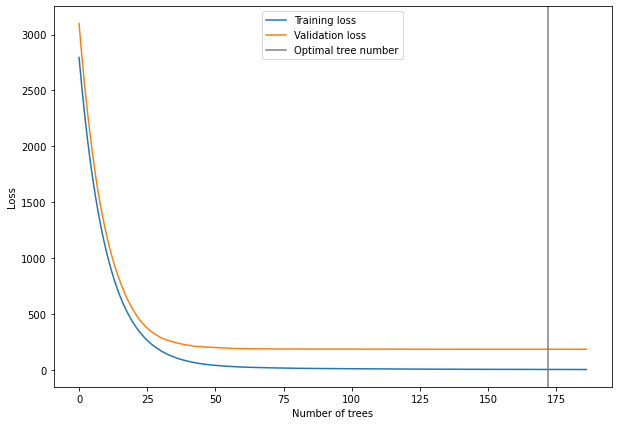

best trees numb: 172


In [8]:
# -> xgboost regressor
# early stopping rounds for xgboost
model = XGBRegressor(n_estimators=300, 
                         max_depth=6, 
                         learning_rate=0.1,
                         seed = 42)
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_val, y_val)], 
          early_stopping_rounds=15,
          verbose=20) 

# plot n° trees (asse x) vs loss function, rmse (asse y)
results = model.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(model.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
plt.show()


best_numb_trees = model.best_ntree_limit
print(f'best trees numb: {best_numb_trees}')

Error on validation data
Mean Squared Error: 47950.0211
Root Mean Sqarred Error: 218.9749
Mean Absolute Error: 107.4276
Mean Absolute Percentage Error: 4.5614


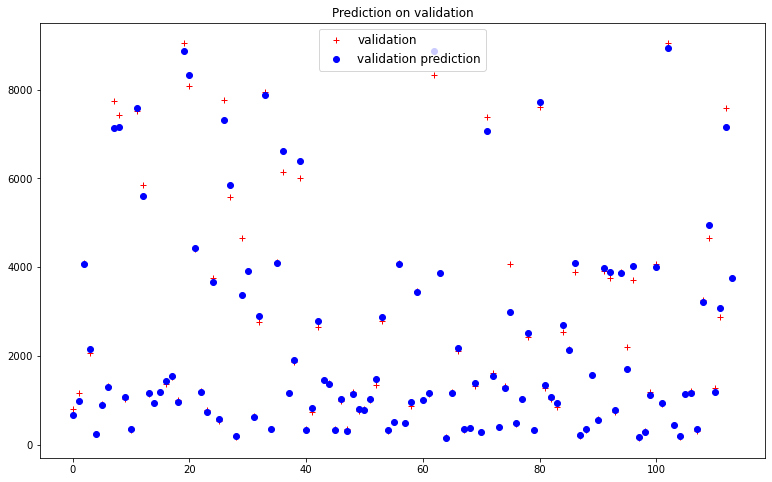

Error on test data
Mean Squared Error: 42750.6758
Root Mean Sqarred Error: 206.7624
Mean Absolute Error: 101.78
Mean Absolute Percentage Error: 4.0714


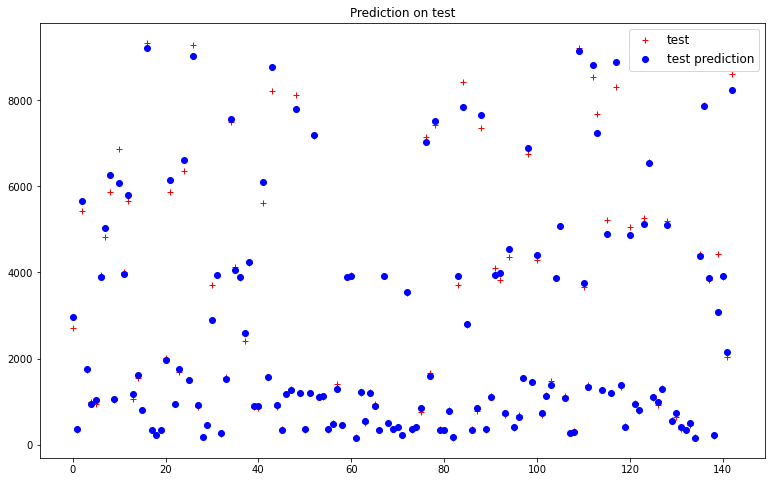


MSE cross validation: 35868.2993
RMSE cross validation: 189.3893


In [6]:
# -> fitting the model
model = XGBRegressor(
#                      booster = 'gbtree',
#                      eval_metric = 'rmse',
#                      objective = 'reg:squarederror',
                     eta = 0.1,
                     min_child_weight = 0.9,
                     max_depth = 5,
                     max_delta_step = 0,
                     subsample = 0.7,
                     colsample_bytree = 0.5,
                     colsample_bylevel = 1,
                     gamma = 1,
                     reg_lambda = 0.4,
                     reg_alpha = 0,
                     n_estimators = best_numb_trees,
                     seed = 42)
model.fit(X_train, y_train)



# prediction of validation
y_pred_val = model.predict(X_val)

# error on validation on the first prediction 
print('Error on validation data')
calcError(y_val,y_pred_val)

# plot train vs val
plt.figure(figsize=(13,8))
plt.plot(y_val.values,'r+',label='validation')
plt.plot(y_pred_val,'bo',label='validation prediction')
plt.legend(prop={'size': 12})
plt.title('Prediction on validation')
plt.show()



# prediction of test 
y_pred_test = model.predict(X_test)

# error on test on the first prediction 
print('Error on test data')
calcError(y_test,y_pred_test)

# plot train vs val
plt.figure(figsize=(13,8))
plt.plot(y_test.values,'r+',label='test')
plt.plot(y_pred_test,'bo',label='test prediction')
plt.legend(prop={'size': 12})
plt.title('Prediction on test')
plt.show()

# error with cross validation on only training set
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model_cv, 
                         X_train, 
                         y_train, 
                         scoring='neg_mean_squared_error', 
                         cv=cv, 
                         n_jobs=-1)

print(f'\nMSE cross validation: {round(abs(scores).mean(),4)}')
print(f'RMSE cross validation: {round(sqrt(abs(scores).mean()),4)}')



In [9]:
# -> tuning xgb parameters
# GridSeadchCV 
parameters = {'max_depth':[4,5,6,7],
              'eta':[0.09,0.1,0.11],
              'reg_lambda' : [0.35,0.4,0.45]}

clf = GridSearchCV(model, 
                   parameters,
                   scoring = 'neg_mean_squared_error',
                   cv = 5,
                   verbose = False)

# fitting on total training set (train + val)                              
clf.fit(X_train_total, y_train_total,verbose = False)

best_estimator = clf.best_estimator_

Error on test data after tuning
Mean Squared Error: 26056.168
Root Mean Sqarred Error: 161.4192
Mean Absolute Error: 86.2771
Mean Absolute Percentage Error: 3.5594


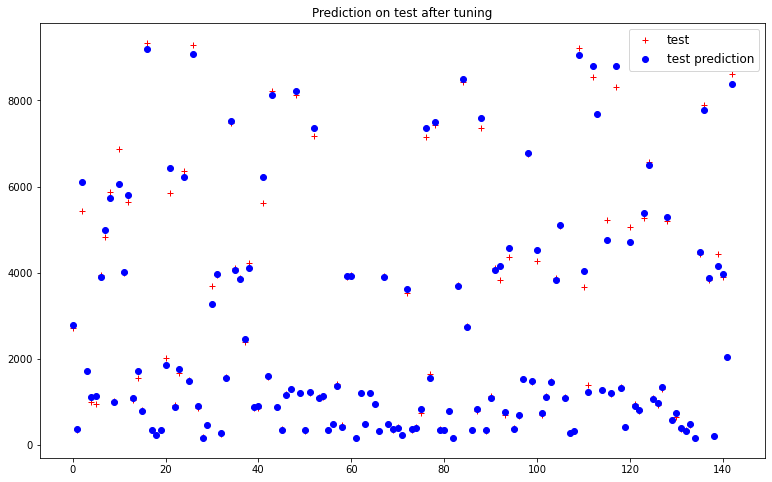


MSE cross validation after tuning: 31510.311
RMSE cross validation after tuning: 177.5114


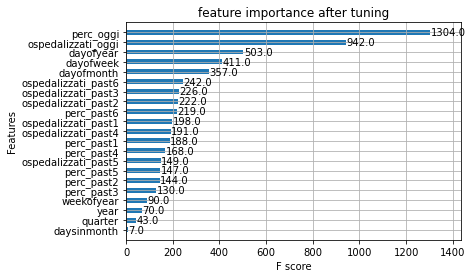

In [11]:
# -> prediction of test after tuning
tune_y_test_pred = best_estimator.predict(X_test)

# error on test on the first prediction 
print('Error on test data after tuning')
calcError(y_test,tune_y_test_pred)

# plot train vs val
plt.figure(figsize=(13,8))
plt.plot(y_test.values,'r+',label='test')
plt.plot(tune_y_test_pred,'bo',label='test prediction')
plt.legend(prop={'size': 12})
plt.title('Prediction on test after tuning')
plt.show()
                              
# error with cross validation on entire training set
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(best_estimator, 
                         X_train_total, 
                         y_train_total, 
                         scoring='neg_mean_squared_error', 
                         cv=cv, 
                         n_jobs=-1)

print(f'\nMSE cross validation after tuning: {round(abs(scores).mean(),4)}')
print(f'RMSE cross validation after tuning: {round(sqrt(abs(scores).mean()),4)}')

# feature importance of tuning xgboost 
plot_importance(model,height=0.5)
plt.title('feature importance after tuning')
plt.show()

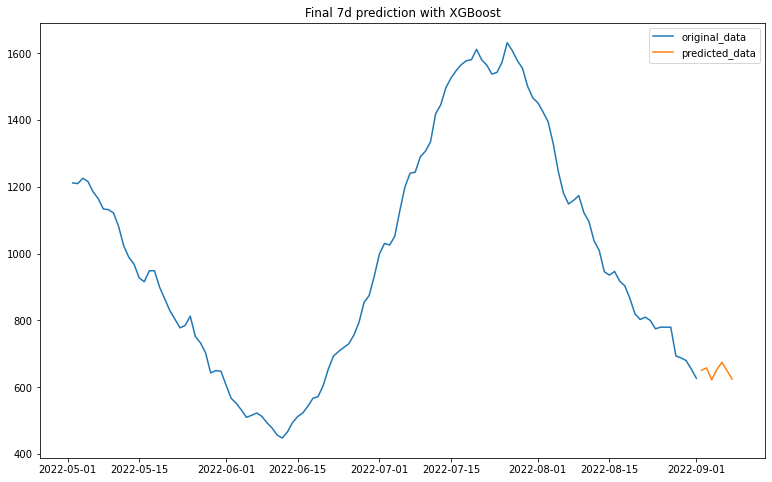

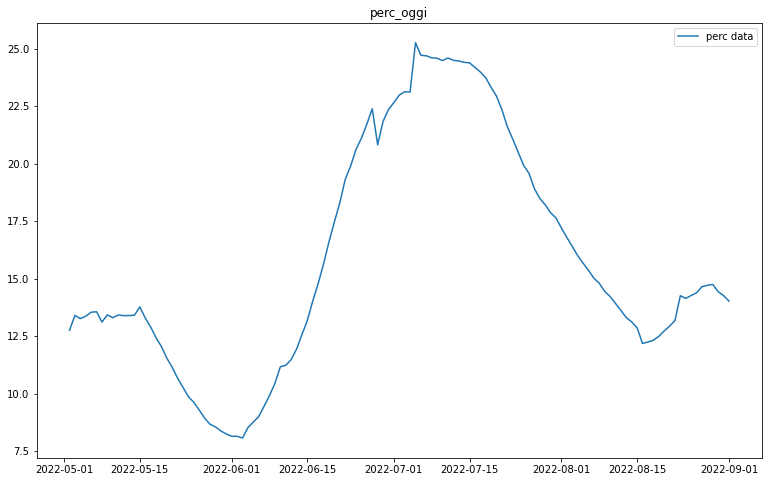

,ospedalizzati_7_days_in_future
2022-09-02,650.687195
2022-09-03,658.080750
2022-09-04,622.649597
2022-09-05,652.914368
2022-09-06,674.797974
2022-09-07,649.902100
2022-09-08,624.360962


In [12]:
# creazione dataframe per predizioni future
data = pd.read_csv('https://www.lombacovid.it/story.csv',usecols = ['data','perc_story','ospedalizzati_story'])
data['data'] = pd.to_datetime(data['data'], dayfirst=True)
data.rename(columns = {'ospedalizzati_story':'ospedalizzati_oggi',
                       'perc_story':'perc_oggi',
                       'data':'date'},
                            inplace = True)
data.set_index('date',inplace=True)

# 1) feature engineering 
# on perc_oggi smoothed by running average of 7 days
running_average = 7     
data['perc_oggi'] = data['perc_oggi'].rolling(window=running_average).mean()
data = data.dropna()

# creation of ospedalizzati and perc_oggi lag features shifted by 10 days: t, t+1, ... t+n
past_days = 7           # <---
for i in range(1, past_days):
    data[f'ospedalizzati_past{i}'] = data['ospedalizzati_oggi'].shift(i).fillna(0)
for i in range(1, past_days):
    data[f'perc_past{i}'] = data['perc_oggi'].shift(i).fillna(0)

# creation of the target: ospedalizzati_oggi lagged by 7 days in the future: t-7
future_target = 7       # <---
data['ospedalizzati_target'] = data['ospedalizzati_oggi'].shift(-future_target).fillna(0)

data = data.fillna(0)

# 2) feature extraction
timeserieFeatureExtractor(data)


from datetime import timedelta
separation_index_prediction = data.index[:-7][-1]
new_pred_index = pd.date_range(separation_index_prediction+timedelta(days=8),periods=7)
data_for_prediction = data[data.index > separation_index_prediction]
x_train_for_prediction = data_for_prediction.drop(columns='ospedalizzati_target')


# predizione di 7 giorni 
new_prediction = best_estimator.predict(x_train_for_prediction)
new_prediction = pd.DataFrame(data=new_prediction,index=new_pred_index)
new_prediction.rename(columns = {0:'ospedalizzati_7_days_in_future'},inplace=True)

plt.figure(figsize=(13,8))
plt.plot(data.ospedalizzati_oggi[data.index > '2022-05-01'],label='original_data')
plt.plot(new_prediction,label='predicted_data')
plt.legend()
plt.title('Final 7d prediction with XGBoost')
plt.show()

# plot perc_oggi 
plt.figure(figsize=(13,8))
plt.plot(data.perc_oggi[data.index > '2022-05-01'],label='perc data')
plt.legend()
plt.title('perc_oggi')
plt.show()

new_prediction

In [13]:
# Paragone tra ospedalizzati tra 7 giorni (7D) e andamento rapporto positivi/tamponi (perc_oggi - pos/tamp) 
# -> dovrebbero avere lo stesso andamento

# creazione nuovo df
new_pred_2 = new_prediction.reset_index(drop=True)
new_perc = data.perc_oggi[data.index >= data.index[-7]].reset_index(drop=True)
new_pred_df = pd.DataFrame(data=new_pred_2)
new_pred_df['old_perc'] = new_perc

# calcoli utili per variazione percentuale giornaliera degli ospedalizzati e pos/tamp
down_perc = new_pred_df.old_perc.shift(1).fillna(method='bfill').values
up_perc = new_pred_df.old_perc.values

down_osp = new_pred_df.ospedalizzati_7_days_in_future.shift(1).fillna(method='bfill').values
up_osp = new_pred_df.ospedalizzati_7_days_in_future.values

change_perc = up_perc/down_perc*100-100
change_osp = up_osp/down_osp*100-100

# direzione degli ospedalizzati_7D e pos/tamp oggi 
what_perc = []
for i in change_perc:
    if i > 0:
        idk = 'up'
    elif i == 0:
        idk = '-'
    else:
        idk = 'down'
    what_perc.append(idk)   
    
what_osp = []
for i in change_osp:
    if i > 0:
        idk = 'up'
    elif i == 0:
        idk = '-'
    else:
        idk = 'down'
    what_osp.append(idk) 
    
# colonne nel nuovo df   
new_pred_df['1_day_change_osp_%'] = change_osp
new_pred_df['1_day_change_perc_%'] = change_perc

new_pred_df['osp_direction'] = what_osp
new_pred_df['perc_direction'] = what_perc



new_pred_df

,ospedalizzati_7_days_in_future,old_perc,1_day_change_osp_%,1_day_change_perc_%,osp_direction,perc_direction
0,650.687195,14.380000,0.000000,0.000000,-,-
1,658.080750,14.650000,1.136269,1.877608,up,up
2,622.649597,14.705714,-5.384010,0.380302,down,up
3,652.914368,14.742857,4.860641,0.252574,up,up
4,674.797974,14.430000,3.351677,-2.122093,up,down
5,649.902100,14.257143,-3.689384,-1.197901,down,down
6,624.360962,14.020000,-3.929993,-1.663327,down,down
